In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math

from scipy.stats import wilcoxon

sns.set_style("whitegrid")

### Read in samples for origin ARS315, set up the annotation of the nucleosome areas

## Wildtype

In [88]:
load_dir =  "ARS315"

In [89]:
wt_rep3 = np.loadtxt(load_dir + "/wt_mat_Megalodon_repIII_ARS315_starting_LexA.txt")

#replicate 2

#rep2_raw = np.genfromtxt("ARS315/mat_Megalodon_repII_ARS315_starting_LexA.txt", delimiter = "\t")
#rep2_raw.shape #1236, 1238 
#np.where(np.isnan(wt_rep2[:, 1])) #smallest value is 697
#select the first 697 rows and save as a separate file
#np.savetxt("ARS315/mat_Megalodon_repII_ARS315_cleaned.txt", rep2_raw[:697,:1236])

wt_rep2 = np.loadtxt(load_dir + "/mat_Megalodon_repII_ARS315_cleaned.txt")

#feature annotation
#anno = pd.read_csv(load_dir + "/Features from ARS315_starting_LexA  (31 .. 1277).txt", sep  = "\t", 
#                          header = None, index_col = 0)
#anno.columns = ["position", "length"]

#anno = pd.read_csv(load_dir + "/coordinates_ARS315.txt", sep  = "\t", 
#                          header = None, index_col = 0)

anno = pd.read_csv(load_dir + "/ARS315_80bp.txt", sep  = "\t", 
                          header = None, index_col = 0)
anno.columns = ["position"]

anno.index = anno.index.astype("string")
anno.index = anno.index.str.strip()

anno["pos_start"] = anno.position.str.split("-").str[0].astype(int) -1
anno["pos_stop"] = anno.position.str.split("-").str[1].astype(int) -1

anno["length"] = anno.pos_stop - anno.pos_start

In [90]:
#Load methylation data for the reverse strand:

wt_rep3_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_repIII_ARS315_starting_LexA.txt")
wt_rep2_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_repII_ARS315_starting_LexA.txt")

dies6_rep1_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20220126_METHYLATION_DIES6_ALL_REP1_ARS315_starting_LexA.txt")
dies6_rep2_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20220207_DIES6_ALLstrains_meth_REP2_ARS315_starting_LexA.txt")

disw2_rep1_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20211201_all_strains_REP1_disw2_ARS315_starting_LexA.txt")
disw2_rep2_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20220221_disw2_all_meth_REP2_ARS315_starting_LexA.txt")

In [91]:
print(wt_rep2.shape[1] == wt_rep3.shape[1])
print(wt_rep3_rev.shape[0] == wt_rep3.shape[0])
print(wt_rep2_rev.shape, wt_rep2.shape)

True
True
(780, 1237) (697, 1236)


In [92]:
def subsample(array, n):
    np.random.seed(15)
    idx = np.random.randint(len(array), size=n)
    return array[idx,:]

wt_rep3_join = np.concatenate((wt_rep3, wt_rep3_rev[:, :-1]), axis = 0)
#subsample wt_rep2_rev to 697 reads
wt_rep2_rev_sub = subsample(wt_rep2_rev, 697)
wt_rep2_join = np.concatenate((wt_rep2, wt_rep2_rev_sub[:, :-1]), axis = 0)

wt_rep3 = wt_rep3_join
wt_rep2 = wt_rep2_join

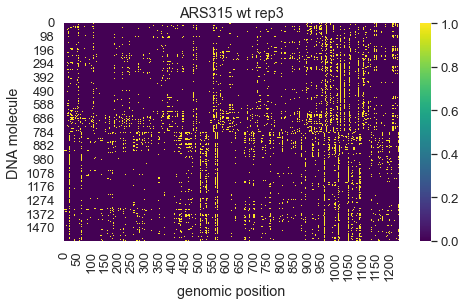

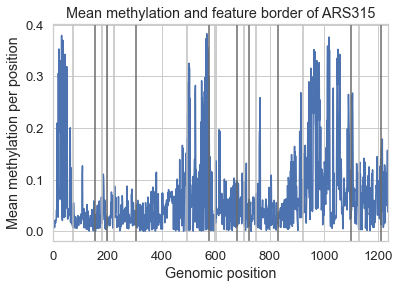

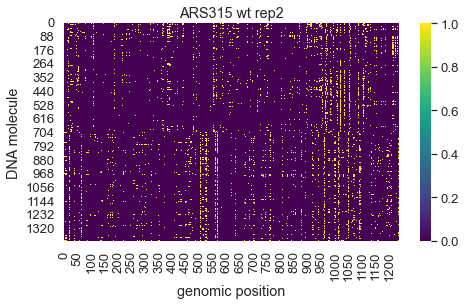

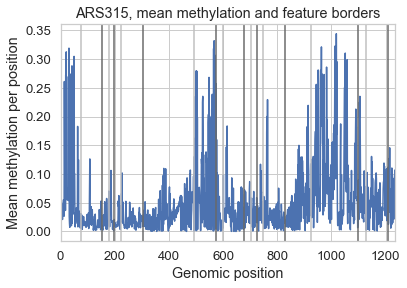

In [93]:
#plot the raw data:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + " wt rep3")
plt.show()

#and the bulk data:
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = wt_rep3.mean(axis = 0)
                )
plt.xlabel("Genomic position")
plt.ylabel("Mean methylation per position")
plt.title("Mean methylation and feature border of " + load_dir)
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

#wildtype replicate 2:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + " wt rep2")
plt.show()

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = wt_rep2.mean(axis = 0)
                )
plt.xlabel("Genomic position")
plt.ylabel("Mean methylation per position")
plt.title(load_dir + ", mean methylation and feature borders")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

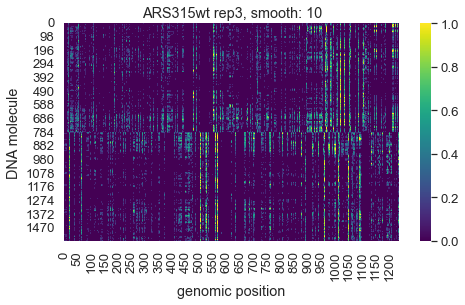

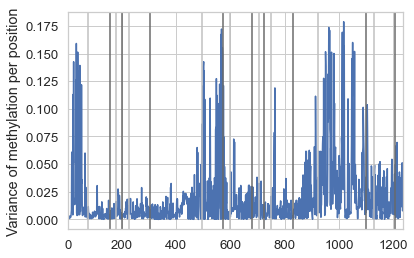

In [94]:
smooth_window = 10

def smooth(array):
        return np.convolve(array, np.ones(smooth_window)/smooth_window, mode = "same")
    
wt_rep3_smooth = np.apply_along_axis(smooth, 0, wt_rep3)
    
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3_smooth, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + "wt rep3, smooth: " + str(smooth_window))
plt.show()

sns.lineplot(x = range(wt_rep3_smooth.shape[1]), 
                 y = wt_rep3_smooth.std(axis = 0)**2
                )
plt.ylabel("Variance of methylation per position")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

In [95]:
#sns.lineplot(x = wt_rep3.shape[1], y = 100 * wt_rep3.cumsum(axis = 0)wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :]/wt_rep3.shape[1])

#wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :].shape
100 * wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :]/wt_rep3.shape[1]

array([ 1.94174757,  0.80906149,  1.21359223, ..., 14.0776699 ,
       19.82200647,  4.77346278])

In [96]:
#this computes the percent of methylation at a specific base
wt_rep3.cumsum(axis = 0)/wt_rep3.shape[1]

#as a measure for the heterogeneity, try the entropy:
# alternatively, try: from scipy.stats import entropy

def entropy(labels, base=None):
    base = 2 if base is None else base
    _ ,counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()

    return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

#https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python

<AxesSubplot:title={'center':'ARS315 wt rep3, entropy per position'}, ylabel='entropy'>

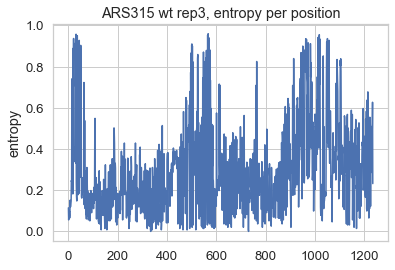

In [97]:
g = sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.apply_along_axis(entropy, 0, wt_rep3))
g.set_ylabel("entropy")
g.set_title(load_dir + " wt rep3, " + "entropy per position")
#g.set_xticks(range(0, ARS305_wt.shape[1], 50))
g

In [98]:
entropy_wt_rep3 = np.apply_along_axis(entropy, 0, wt_rep3)
entropy_wt_rep3.min(), entropy_wt_rep3.max(), np.count_nonzero(entropy_wt_rep3)

(-0.0, 0.9599213421545211, 1234)

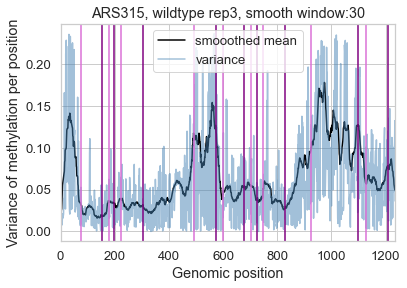

In [99]:
N = 30

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(N)/N, mode ="same"),
             color = "black", label = "smooothed mean")
#plt.ylabel("Mean methylation over sample")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir +  ", wildtype rep3, smooth window:" + str(N))


sns.lineplot(x = range(wt_rep3.shape[1]), 
            y = wt_rep3.std(axis = 0)**2, color = "steelblue", alpha = 0.5,
            label = "variance"
            )
plt.ylabel("Variance of methylation per position")
plt.xlabel("Genomic position")
#plt.axvline(62, color = "purple", label = "border")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "orchid")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "purple")

## Load data for mutant dies6

In [100]:
dies6_rep1 = np.loadtxt(load_dir + "/DIES6_ALL_REP1_ARS315_starting_LexA.txt")
print(dies6_rep1.shape, dies6_rep1_rev.shape)

dies6_rep2 = np.genfromtxt(load_dir + "/DIES6_ARS315_REP2_780READS.csv", dtype = int, delimiter = ",")
print(dies6_rep2.shape, dies6_rep2_rev.shape)

(780, 1236) (780, 1237)
(780, 1236) (780, 1237)


In [101]:
#join the plus and minus strand, no subsampling
dies6_rep1_join = np.concatenate((dies6_rep1, dies6_rep1_rev[:, :-1]), axis = 0)
dies6_rep2_join = np.concatenate((dies6_rep2, dies6_rep2_rev[:, :-1]), axis = 0)

#rename joined samples to run the rest of the pipeline with it

dies6_rep1 = dies6_rep1_join.copy()
dies6_rep2 = dies6_rep2_join.copy()

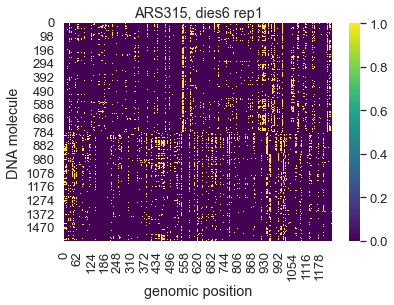

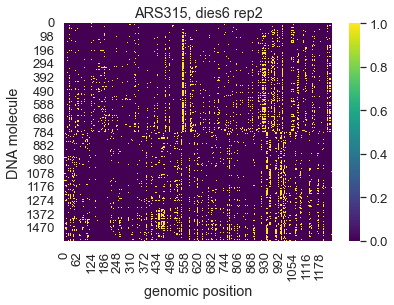

In [102]:
sns.heatmap(dies6_rep1, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep1.shape[1])
plt.title(load_dir + ", dies6 rep1")
plt.show()

sns.heatmap(dies6_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep2.shape[1])
plt.title(load_dir + ", dies6 rep2")
plt.show()

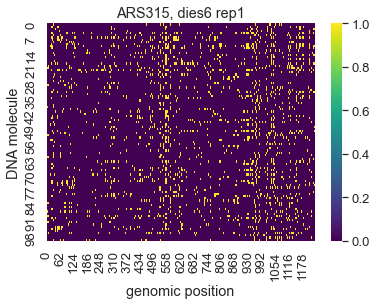

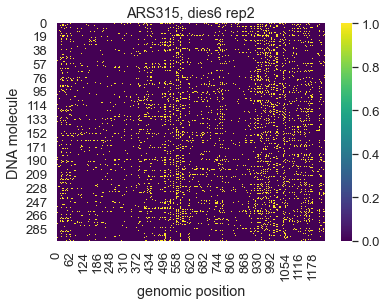

In [103]:
#subsample to the same number of molecules than in 316
#rep1 -> 83
#rep2 -> 301

def subsample(array, n):
    np.random.seed(15)
    idx = np.random.randint(len(array), size=n)
    return array[idx,:]

test1 = subsample(dies6_rep1, 100)
test2 = subsample(dies6_rep2, 300)

sns.heatmap(test1, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep1.shape[1])
plt.title(load_dir + ", dies6 rep1")
plt.show()

sns.heatmap(test2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep2.shape[1])
plt.title(load_dir + ", dies6 rep2")
plt.show()

In [104]:
#dies6_rep1 = subsample(dies6_rep1, 83)
#dies6_rep2 = subsample(dies6_rep2, 301)

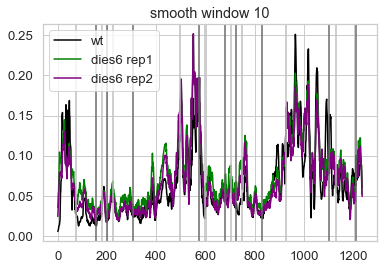

(137640.0, 1.4171724992925624e-84)

In [105]:
#smooth = 1

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(dies6_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "green", label = "dies6 rep1")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(dies6_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "purple", label = "dies6 rep2")
plt.title("smooth window " + str(smooth_window))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

wt_rep3_smooth_mean = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
dies6_rep1_smooth_mean = np.convolve(dies6_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
dies6_rep2_smooth_mean = np.convolve(dies6_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")

means = np.concatenate((wt_rep3_smooth_mean.reshape(1, wt_rep3.shape[1]), 
                        dies6_rep1_smooth_mean.reshape(1, wt_rep3.shape[1]),
                        dies6_rep2_smooth_mean.reshape(1, wt_rep3.shape[1])),
                              axis = 0)

from scipy.stats import wilcoxon

w, p = wilcoxon(means[0,:], means[1,:], alternative = "two-sided")
w,p

In [106]:
#statistical test to compare replicates of the mutants: 
wilcoxon(dies6_rep1.mean(axis = 0), 
         dies6_rep2.mean(axis = 0), alternative = "two-sided")

WilcoxonResult(statistic=118668.5, pvalue=2.7738132379189148e-90)

## Load data for mutant disw2

In [107]:
disw2_rep1 = np.genfromtxt(load_dir + "/ARS315_disw2_rep1_780READS_noNA.csv", dtype = int,
                                 delimiter = ",")
print(disw2_rep1.shape, disw2_rep1_rev.shape)

disw2_rep2 = np.genfromtxt(load_dir + "/ARS315_disw2_rep2_780READS_noNA.csv", dtype = int, delimiter = ",")
print(disw2_rep2.shape, disw2_rep2_rev.shape)

(780, 1236) (780, 1237)
(780, 1236) (780, 1237)


In [108]:
#join the plus and minus strand, no subsampling here

disw2_rep1_join = np.concatenate((disw2_rep1, disw2_rep1_rev[:, :-1]), axis = 0)
disw2_rep2_join = np.concatenate((disw2_rep2, disw2_rep2_rev[:, :-1]), axis = 0)

#rename joined samples to run the rest of the pipeline with it

disw2_rep1 = disw2_rep1_join.copy()
disw2_rep2 = disw2_rep2_join.copy()

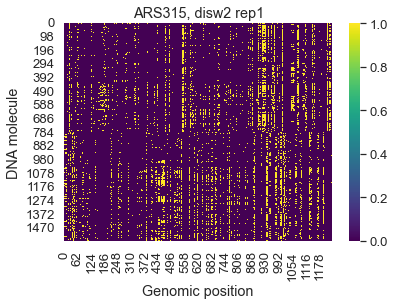

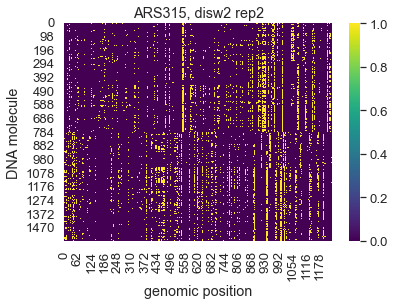

In [109]:
sns.heatmap(disw2_rep1, cmap = "viridis")
plt.xlabel("Genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, disw2_rep1.shape[1])
plt.title(load_dir + ", disw2 rep1")
plt.show()


sns.heatmap(disw2_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, disw2_rep2.shape[1])
plt.title(load_dir + ", disw2 rep2")
plt.show()

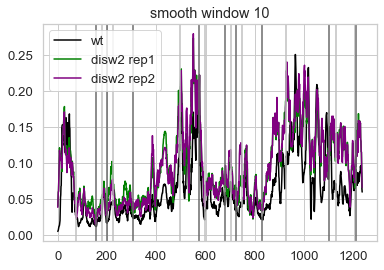

In [110]:
#smooth = 1

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(disw2_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "green", label = "disw2 rep1")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(disw2_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "purple", label = "disw2 rep2")
plt.title("smooth window " + str(smooth_window))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

In [111]:
# calculate the mean over all molecules and smooth with window size "smooth"

disw2_rep1_smooth_mean = np.convolve(disw2_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
disw2_rep2_smooth_mean = np.convolve(disw2_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")

means = np.concatenate((means, 
                        disw2_rep1_smooth_mean.reshape(1, wt_rep3.shape[1]),
                        disw2_rep2_smooth_mean.reshape(1, wt_rep3.shape[1])),
                        axis = 0)

w, p = wilcoxon(disw2_rep1.mean(axis = 0),
                disw2_rep2.mean(axis = 0), alternative = "two-sided")
w,p

(355832.0, 0.7470439131407984)

In [151]:
#summarise samples
array_dic = {"wt_rep3": wt_rep3_join, 
             "wt_rep2": wt_rep2_join, 
             "dies6_rep1": dies6_rep1_join,
            "dies6_rep2": dies6_rep2_join,
            "disw2_rep1": disw2_rep1_join,
            "disw2_rep2": disw2_rep2_join}

summary=pd.DataFrame()
for element in array_dic.keys():
    summary[element] = pd.DataFrame(array_dic[element].mean(axis=0)).describe()
summary = summary.T
summary["#molecules"] = [array_dic[sample].shape[0] for sample in summary.index]
#summary = summary.T
summary

,count,mean,std,min,25%,50%,75%,max,#molecules
wt_rep3,1236.0,0.064448,0.070022,0.0,0.020513,0.042949,0.080769,0.382692,1560
wt_rep2,1236.0,0.051675,0.060361,0.0,0.014347,0.031564,0.062410,0.344333,1394
dies6_rep1,1236.0,0.076884,0.069479,0.0,0.022276,0.062821,0.107051,0.389744,1560
dies6_rep2,1236.0,0.068379,0.068316,0.0,0.017308,0.050000,0.092949,0.396154,1560
disw2_rep1,1236.0,0.095764,0.088852,0.0,0.018429,0.078526,0.139744,0.421795,1560
disw2_rep2,1236.0,0.095653,0.089790,0.0,0.021795,0.071474,0.137340,0.423718,1560


## Min-max normalise each experiment and pool replicates

In [145]:
"""wt_rep3_minmax = wt_rep3.mean(axis = 0)/wt_rep3.mean(axis = 0).max()
wt_rep2_minmax = wt_rep2.mean(axis = 0)/wt_rep2.mean(axis = 0).max()

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1.mean(axis = 0)/dies6_rep1.mean(axis = 0).max()
dies6_rep2_minmax = dies6_rep2.mean(axis = 0)/dies6_rep2.mean(axis = 0).max()

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1.mean(axis = 0)/disw2_rep1.mean(axis = 0).max()
disw2_rep2_minmax = disw2_rep2.mean(axis = 0)/disw2_rep2.mean(axis = 0).max()

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)"""


#normalise to the nucleosomal array spike-ins
mean_array_wt_rep3 = 0.048283
mean_array_wt_rep2 = 0.034160
mean_array_dies6_rep1=0.050732
mean_array_dies6_rep2 = 0.045048
mean_array_disw2_rep1 = 0.061350
mean_array_disw2_rep2 = 0.059359

wt_rep3_minmax = wt_rep3.mean(axis = 0)/mean_array_wt_rep3
wt_rep2_minmax = wt_rep2.mean(axis = 0)/mean_array_wt_rep2

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1.mean(axis = 0)/mean_array_dies6_rep1
dies6_rep2_minmax = dies6_rep2.mean(axis = 0)/mean_array_dies6_rep2

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1.mean(axis = 0)/mean_array_disw2_rep1
disw2_rep2_minmax = disw2_rep2.mean(axis = 0)/mean_array_disw2_rep2

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)



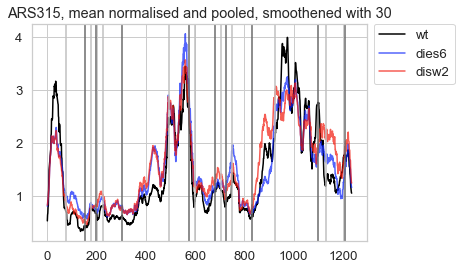

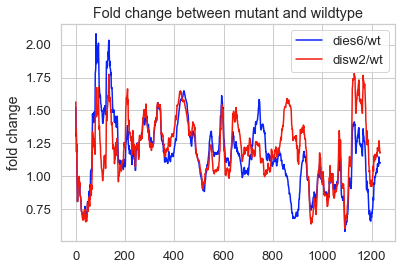

In [150]:
N=30

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"), #wt_min_max
             color = "black", 
            label = "wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), #dies6_min_max
             color = "#0a22fa", alpha = 0.7,
            label = "dies6")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), #disw2_min_max
            color = "#f2180c", alpha = 0.7,
            label = "disw2")
plt.title(load_dir +  ", mean normalised and pooled, smoothened with " + str(N)) #pooled and min-max normalised
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
#plt.savefig("ARS315/plots/ARS315_both_strands_average_methylation.png", dpi = 300)
plt.show()

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "#0a22fa", 
             label = "dies6/wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_disw2, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "#f2180c",
             label = "disw2/wt")
plt.ylabel("fold change")
plt.title("Fold change between mutant and wildtype")
#plt.savefig("ARS315/plots/ARS315_fold_changes.png", dpi = 300)
plt.show()

### Compare mean distributions between pooled replicates and pooled wildtype with paired wilcoxon test

In [147]:
segments = anno.drop(columns = "position")

#list comprehension to catch the pooled methylation values per sample in a cell per column
array_list = [pooled_wt[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["wt_mean"] = pd.Series(array_list, index = segments.index)

#dies6 mutant 
array_list = [pooled_dies6[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["dies6_mean"] = pd.Series(array_list, index = segments.index)

#disw2 mutant

array_list = [pooled_disw2[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["disw2_mean"] = pd.Series(array_list, index = segments.index)

In [148]:
segments["p_value_dies6"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_disw2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments.drop(segments.columns[3:6], axis =1, inplace = True)

In [149]:
#segments.to_csv(load_dir + "/ARS315_pooled_samples_two-sided-test.csv")
segments

,pos_start,pos_stop,length,p_value_dies6,p_value_disw2
0,,,,,
-2 NS,74,154,80,1.428639e-07,0.007881
-1 L,179,199,20,8.983173e-01,0.869488
-1NS,224,304,80,2.896684e-03,0.008950
ARS315,494,574,80,1.248300e-01,0.180843
+1ns,599,679,80,5.064752e-04,0.000721
+1L,704,724,20,6.372261e-02,0.023951
+2ns,749,829,80,8.907710e-05,0.033209
prom,924,1099,175,5.511840e-01,0.827791
+3ns,1129,1209,80,1.855777e-01,0.001823


In [117]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the dies6 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_dies6"] < pvalue)]

       Which sites have a different mean methylation in the dies6 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6,p_value_disw2
0,,,,,
-2 NS,74,154,80,3.865681e-09,3.157642e-04
-1NS,224,304,80,7.087320e-04,2.173585e-04
ARS315,494,574,80,7.745519e-05,1.852464e-07
+1ns,599,679,80,8.824279e-07,9.950926e-09
+1L,704,724,20,1.718140e-02,4.859924e-03
+2ns,749,829,80,1.153658e-06,3.059455e-06


In [118]:
#Regions significant for disw2:
print("       Which sites have a different mean methylation in the disw2 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_disw2"] < pvalue)]

       Which sites have a different mean methylation in the disw2 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6,p_value_disw2
0,,,,,
-2 NS,74,154,80,3.865681e-09,3.157642e-04
-1NS,224,304,80,7.087320e-04,2.173585e-04
ARS315,494,574,80,7.745519e-05,1.852464e-07
+1ns,599,679,80,8.824279e-07,9.950926e-09
+1L,704,724,20,1.718140e-02,4.859924e-03
+2ns,749,829,80,1.153658e-06,3.059455e-06
prom,924,1099,175,6.874698e-01,2.210321e-02
+3ns,1129,1209,80,6.983235e-02,1.654343e-05


## Condense segment information for statistical testing of methylation per feature window
### Compare pooled wildtype to mutant replicates, then filter regions

In [119]:
segments = anno.drop(columns = "position")

#list comprehension to catch the pooled methylation values per sample in a cell per column
array_list = [pooled_wt[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["wt_mean"] = pd.Series(array_list, index = segments.index)

#dies6 mutant 
array_list = [dies6_rep1_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_mean_rep1"] = pd.Series(array_list, index = segments.index)

array_list = [dies6_rep2_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_mean_rep2"] = pd.Series(array_list, index = segments.index)


#disw2 mutant
array_list = [disw2_rep1_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_mean_rep1"] = pd.Series(array_list, index = segments.index)

array_list = [disw2_rep2_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_mean_rep2"] = pd.Series(array_list, index = segments.index)

In [120]:
#perform statistical test
segments["p_value_dies6_rep1"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean_rep1"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments["p_value_dies6_rep2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean_rep2"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_disw2_rep1"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean_rep1"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments["p_value_disw2_rep2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean_rep2"],
                                                alternative = "two-sided").pvalue for index in segments.index]

test_higher = segments.iloc[:, :8]
segments.drop(segments.columns[3:8], axis =1, inplace = True)

In [121]:
#segments.to_csv(load_dir + "/ARS315_separate_replicates_two-sided-test.csv")
segments

,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
-2 NS,74,154,80,7.280521e-09,6.682650e-09,1.763440e-04,1.205845e-03
-1 L,179,199,20,6.476555e-01,7.285061e-01,2.305126e-01,5.216732e-01
-1NS,224,304,80,2.987220e-04,9.868522e-03,2.479545e-04,1.454808e-04
ARS315,494,574,80,1.023306e-04,2.526365e-04,6.731520e-07,4.201728e-08
+1ns,599,679,80,1.465475e-09,6.909580e-02,6.876430e-09,1.212287e-08
+1L,704,724,20,7.295609e-03,1.429062e-01,6.389618e-03,4.220963e-03
+2ns,749,829,80,8.440341e-08,2.526417e-04,6.985787e-06,1.956010e-06
prom,924,1099,175,2.518842e-01,7.430683e-01,4.288119e-02,9.651452e-03
+3ns,1129,1209,80,2.478981e-02,1.345386e-01,1.584090e-05,1.727560e-05


In [122]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the dies6 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_dies6_rep1"] < pvalue) &
            (segments["p_value_dies6_rep2"] < pvalue)]

       Which sites have a different mean methylation in the dies6 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
-2 NS,74,154,80,7.280521e-09,6.682650e-09,1.763440e-04,1.205845e-03
-1NS,224,304,80,2.987220e-04,9.868522e-03,2.479545e-04,1.454808e-04
ARS315,494,574,80,1.023306e-04,2.526365e-04,6.731520e-07,4.201728e-08
+2ns,749,829,80,8.440341e-08,2.526417e-04,6.985787e-06,1.956010e-06


In [123]:
#Regions significant for disw2:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the disw2 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_disw2_rep1"] < pvalue) &
            (segments["p_value_disw2_rep2"] < pvalue)]

       Which sites have a different mean methylation in the disw2 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
-2 NS,74,154,80,7.280521e-09,6.682650e-09,1.763440e-04,1.205845e-03
-1NS,224,304,80,2.987220e-04,9.868522e-03,2.479545e-04,1.454808e-04
ARS315,494,574,80,1.023306e-04,2.526365e-04,6.731520e-07,4.201728e-08
+1ns,599,679,80,1.465475e-09,6.909580e-02,6.876430e-09,1.212287e-08
+1L,704,724,20,7.295609e-03,1.429062e-01,6.389618e-03,4.220963e-03
+2ns,749,829,80,8.440341e-08,2.526417e-04,6.985787e-06,1.956010e-06
+3ns,1129,1209,80,2.478981e-02,1.345386e-01,1.584090e-05,1.727560e-05


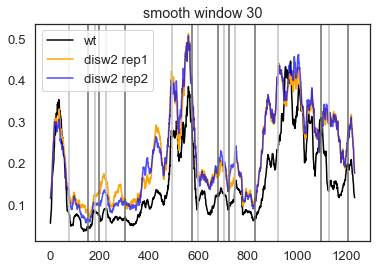

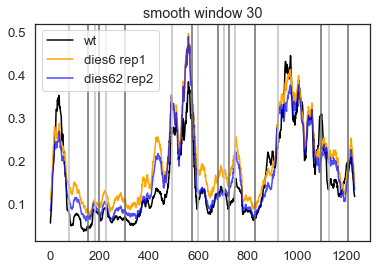

In [124]:
# How does that look over the whole sequence?
smooth_width = 30
sns.set_style("white")

sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(disw2_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "orange", label = "disw2 rep1")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(disw2_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "blue", alpha = 0.7, label = "disw2 rep2")
plt.title("smooth window " + str(smooth_width))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
#plt.savefig(load_dir + "/plots/ARS315_averaged_meth_disw2_replicates.png", dpi=300)
plt.show()

sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(dies6_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "orange", label = "dies6 rep1")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(dies6_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "blue", alpha = 0.7, label = "dies62 rep2")
plt.title("smooth window " + str(smooth_width))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
#plt.savefig(load_dir + "/plots/ARS315_averaged_meth_dies6_replicates.png", dpi=300)
plt.show()

In [125]:
#Repeat this test for the hypothesis that methylation in one fragment is higher than in wildtype:

test_higher["p_value_dies6_rep1"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"dies6_mean_rep1"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_dies6_rep2"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"dies6_mean_rep2"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_disw2_rep1"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"disw2_mean_rep1"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_disw2_rep2"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"disw2_mean_rep2"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher.drop(test_higher.columns[3:8], axis=1, inplace = True)

In [126]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a higher mean methylation for the dies6 mutant?")
test_higher.loc[(test_higher["p_value_dies6_rep1"] < pvalue) & 
         (test_higher["p_value_dies6_rep2"] < pvalue)]

       Which sites have a higher mean methylation for the dies6 mutant?


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
-2 NS,74,154,80,3.640261e-09,3.341325e-09,8.817199e-05,6.029227e-04
-1NS,224,304,80,1.493610e-04,4.934261e-03,1.239773e-04,7.274041e-05
ARS315,494,574,80,5.116532e-05,1.263182e-04,3.365760e-07,2.100864e-08
+2ns,749,829,80,4.220171e-08,1.263208e-04,3.492893e-06,9.780050e-07


In [127]:
#Regions significant for disw2:
pvalue = 2.5e-2

print("       Which sites have a higher mean methylation for the disw2 mutant?")
test_higher.loc[(test_higher["p_value_disw2_rep1"] < pvalue) & 
         (test_higher["p_value_disw2_rep2"] < pvalue)]

       Which sites have a higher mean methylation for the disw2 mutant?


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
-2 NS,74,154,80,3.640261e-09,3.341325e-09,8.817199e-05,6.029227e-04
-1NS,224,304,80,1.493610e-04,4.934261e-03,1.239773e-04,7.274041e-05
ARS315,494,574,80,5.116532e-05,1.263182e-04,3.365760e-07,2.100864e-08
+1ns,599,679,80,7.327374e-10,3.454790e-02,3.438215e-09,6.061437e-09
+1L,704,724,20,3.647804e-03,7.145309e-02,3.194809e-03,2.110481e-03
+2ns,749,829,80,4.220171e-08,1.263208e-04,3.492893e-06,9.780050e-07
prom,924,1099,175,1.259421e-01,6.284658e-01,2.144059e-02,4.825726e-03
+3ns,1129,1209,80,1.239491e-02,6.726931e-02,7.920448e-06,8.637802e-06


## Show the average methylation by feature for each of the conditions

In [128]:
#Display the mean methylation per feature

def condense_features(array, anno):
    output = np.empty(array.shape[0],)
    for index in anno.index:
        feature_array = array[:, anno.loc[index, "pos_start"]: anno.loc[index, "pos_stop"]]
        means_by_feature = np.apply_along_axis(np.mean, 1, feature_array)
        output = np.column_stack((output, means_by_feature))
    return output[:, 1:]

def max_normalise_array(array):
    return array/array.mean(axis=0).max()

In [129]:
#normalize the count matrices to the max of averages of the respective sample
wt_rep3_maxnorm = max_normalise_array(wt_rep3)
wt_rep2_maxnorm = max_normalise_array(wt_rep2)

dies6_rep1_maxnorm = max_normalise_array(dies6_rep1)
dies6_rep2_maxnorm = max_normalise_array(dies6_rep2)

disw2_rep1_maxnorm = max_normalise_array(disw2_rep1)
disw2_rep2_maxnorm = max_normalise_array(disw2_rep2)

#condense methylation by feature 
wt_rep3_feat_me = condense_features(wt_rep3_maxnorm, anno)
wt_rep2_feat_me = condense_features(wt_rep2_maxnorm, anno)

wt_pool = np.concatenate((wt_rep3_feat_me, wt_rep2_feat_me), axis = 0)

dies6_rep1_feat_me = condense_features(dies6_rep1_maxnorm, anno)
dies6_rep2_feat_me = condense_features(dies6_rep2_maxnorm, anno)

dies6_pool = np.concatenate((dies6_rep1_feat_me, dies6_rep2_feat_me), axis= 0)

disw2_rep1_feat_me = condense_features(disw2_rep1_maxnorm, anno)
disw2_rep2_feat_me = condense_features(disw2_rep2_maxnorm, anno)

disw2_pool = np.concatenate((disw2_rep1_feat_me, disw2_rep2_feat_me), axis = 0)

Comparing replicates


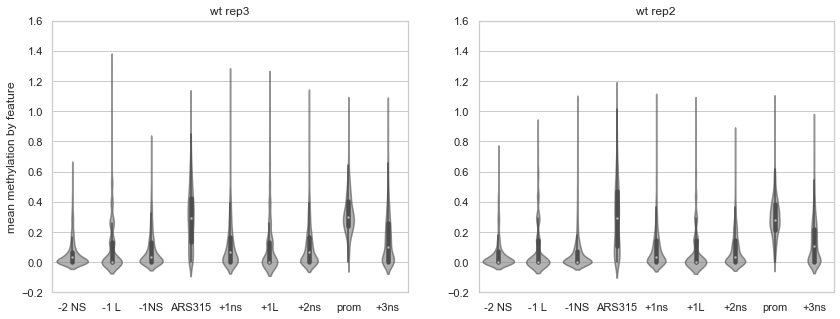

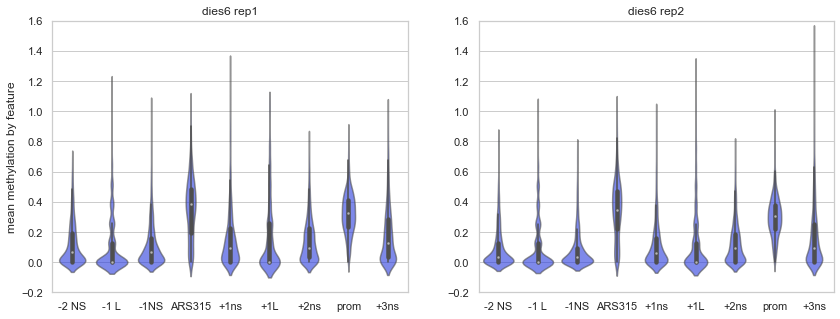

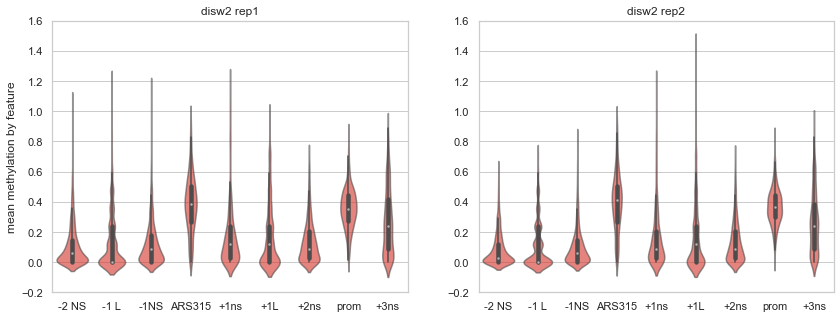

In [130]:
sns.set(font_scale=1)
sns.set_style("whitegrid")

print("Comparing replicates")
#wt
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))

sns.violinplot(data = wt_rep3_feat_me, axis = 1, color = "grey", ax=ax1)
ax1.set_title("wt rep3")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-0.2,1.6)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = wt_rep2_feat_me, axis = 1, color = "grey", ax=ax2)
ax2.set_title("wt rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-0.2,1.6)
plt.setp(ax2.collections, alpha = 0.6)
plt.savefig(load_dir + "/plots/ARS315_methylation_by_feature_wt.tif")
plt.show()

#dies6
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.violinplot(data = dies6_rep1_feat_me, axis = 1, color = "#0a22fa", ax=ax1)
ax1.set_title("dies6 rep1")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-0.2,1.6)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = dies6_rep2_feat_me, axis = 1, color = "#0a22fa", ax=ax2)
ax2.set_title("dies6 rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-0.2,1.6)
plt.setp(ax2.collections, alpha = 0.6)
plt.savefig(load_dir + "/plots/ARS315_methylation_by_feature_dies6.tif")
plt.show()

#disw2
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.violinplot(data = disw2_rep1_feat_me, axis = 1, color = "#f2180c", ax=ax1)
ax1.set_title("disw2 rep1")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-0.2,1.6)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = disw2_rep2_feat_me, axis = 1, color = "#f2180c", ax=ax2)
ax2.set_title("disw2 rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-0.2,1.6)
plt.setp(ax2.collections, alpha = 0.6)
plt.savefig(load_dir + "/plots/ARS315_methylation_by_feature_disw2.tif")
plt.show()

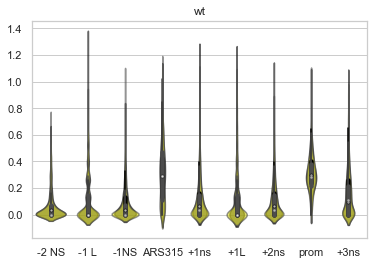

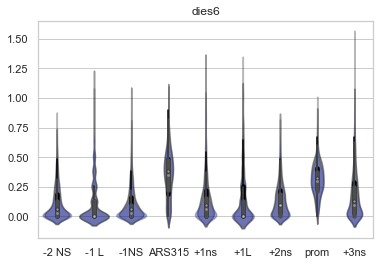

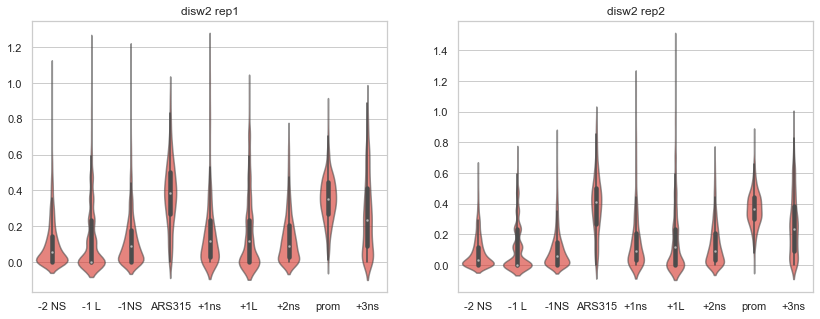

In [131]:
sns.set(font_scale=1)
sns.set_style("whitegrid")
#wt

g = sns.violinplot(data = wt_rep3_feat_me, axis = 1, color = "black", label = "rep3")
g.set_title("wt")

sns.violinplot(data = wt_rep2_feat_me, axis = 1, color = "yellow", label = "rep2")
g.set_xticklabels(anno.index)
plt.setp(g.collections, alpha = 0.6)
plt.show()

#dies6
f = sns.violinplot(data = dies6_rep1_feat_me, axis = 1, color = "black")
f.set_title("dies6")

sns.violinplot(data = dies6_rep2_feat_me, axis = 1, color = "#0a22fa")
f.set_xticklabels(anno.index)
plt.setp(f.collections, alpha = 0.4)
plt.show()

#disw2
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.violinplot(data = disw2_rep1_feat_me, axis = 1, color = "#f2180c", ax=ax1)
ax1.set_title("disw2 rep1")
ax1.set_xticklabels(anno.index)
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = disw2_rep2_feat_me, axis = 1, color = "#f2180c", ax=ax2)
ax2.set_title("disw2 rep2")
ax2.set_xticklabels(anno.index)
plt.setp(ax2.collections, alpha = 0.6)
plt.show()

In [132]:
#Combine the violinplots into one plot per replicate:
#for each feature, plot wt and mutants next to each other

#transfer array to dataframe, melt that into the long form and assign a catergory "condition"
feat_me_wt_rep3 = pd.DataFrame(wt_rep3_feat_me, columns = anno.index)
feat_me_wt_rep3["molecule"] = feat_me_wt_rep3.index
feat_me_wt_rep3_melt = pd.melt(feat_me_wt_rep3, id_vars=("molecule"), var_name = ("feature"))
feat_me_wt_rep3_melt["condition"] = "wt rep3"

feat_me_wt_pool = pd.DataFrame(wt_pool, columns = anno.index)
feat_me_wt_pool["molecule"] = feat_me_wt_pool.index
feat_me_wt_melt = pd.melt(feat_me_wt_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_wt_melt["condition"] = "wt"


#the same for dies6
feat_me_dies6_rep2 = pd.DataFrame(dies6_rep2_feat_me, columns = anno.index)
feat_me_dies6_rep2["molecule"] = feat_me_dies6_rep2.index

feat_me_dies6_rep2_melt = pd.melt(feat_me_dies6_rep2, id_vars=("molecule"), var_name = ("feature"))
feat_me_dies6_rep2_melt["condition"] = "dies6"

feat_me_dies6_pool = pd.DataFrame(dies6_pool, columns = anno.index)
feat_me_dies6_pool["molecule"] = feat_me_dies6_pool.index
feat_me_dies6_melt = pd.melt(feat_me_dies6_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_dies6_melt["condition"] = "dies6"

#the same for disw2
feat_me_disw2_rep1 = pd.DataFrame(disw2_rep1_feat_me, columns = anno.index)
feat_me_disw2_rep1["molecule"] = feat_me_disw2_rep1.index

feat_me_disw2_rep1_melt = pd.melt(feat_me_disw2_rep1, id_vars=("molecule"), var_name = ("feature"))
feat_me_disw2_rep1_melt["condition"] = "disw2"

feat_me_disw2_pool = pd.DataFrame(disw2_pool, columns = anno.index)
feat_me_disw2_pool["molecule"] = feat_me_disw2_pool.index
feat_me_disw2_melt = pd.melt(feat_me_disw2_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_disw2_melt["condition"] = "disw2"

#merge into one dataframe:
methylation_rep1 = pd.concat([feat_me_wt_melt, feat_me_dies6_melt, feat_me_disw2_melt])
methylation_rep1.rename(columns = {"value" : "mean methylation"}, inplace=True)

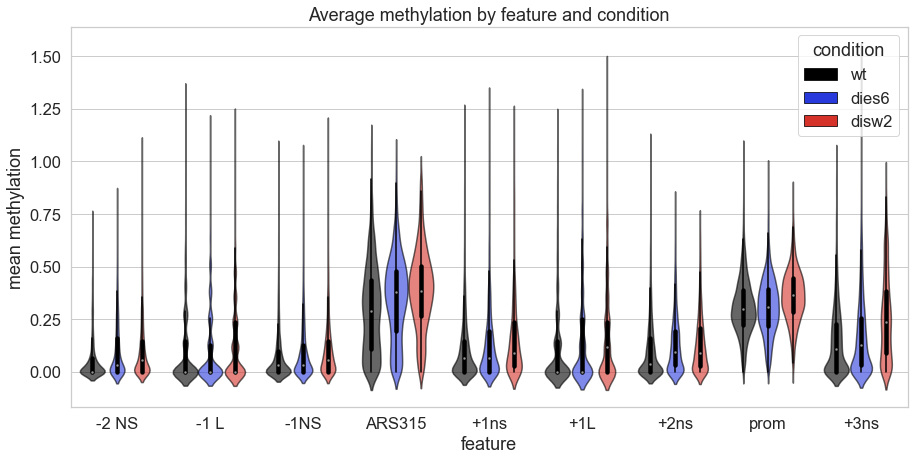

In [133]:
col_Anna = ["black", "#0a22fa", "#f2180c"]

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

plt.figure(figsize = (15,7))
ax = sns.violinplot(data = methylation_rep1, x="feature", y = "mean methylation", hue = "condition", 
                    palette = col_Anna)
plt.setp(ax.collections, alpha = 0.6)
plt.title("Average methylation by feature and condition")
#plt.savefig(load_dir + "/plots/ARS315_pooled_av_methylation_by_feature_anno3.tif", dpi = 300)
plt.show()

In [134]:
#Calculate p-values for the distributions in the violins using the mann-whitney U test

from scipy.stats import mannwhitneyu

feature_pvalues = anno.drop(columns = "position")
feature_pvalues["dies6_rep2"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_dies6_rep2.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]
feature_pvalues["disw2_rep1"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_disw2_rep1.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]

feature_pvalues

,pos_start,pos_stop,length,dies6_rep2,disw2_rep1
0,,,,,
-2 NS,74,154,80,4.142615e-15,4.829359e-46
-1 L,179,199,20,2.639987e-01,2.961170e-11
-1NS,224,304,80,3.069349e-02,9.406225e-50
ARS315,494,574,80,4.679737e-16,2.290951e-44
+1ns,599,679,80,6.751772e-01,2.078556e-29
+1L,704,724,20,9.280522e-01,2.601416e-21
+2ns,749,829,80,1.450348e-10,1.691573e-29
prom,924,1099,175,1.300188e-01,4.635159e-34
+3ns,1129,1209,80,8.677813e-01,7.183955e-71


In [135]:
feature_pvalues[feature_pvalues.dies6_rep2 < 2.5e-2]

,pos_start,pos_stop,length,dies6_rep2,disw2_rep1
0,,,,,
-2 NS,74,154,80,4.142615e-15,4.829359e-46
ARS315,494,574,80,4.679737e-16,2.290951e-44
+2ns,749,829,80,1.450348e-10,1.691573e-29


In [136]:
feature_pvalues[feature_pvalues.disw2_rep1 < 2.5e-2]

,pos_start,pos_stop,length,dies6_rep2,disw2_rep1
0,,,,,
-2 NS,74,154,80,4.142615e-15,4.829359e-46
-1 L,179,199,20,2.639987e-01,2.961170e-11
-1NS,224,304,80,3.069349e-02,9.406225e-50
ARS315,494,574,80,4.679737e-16,2.290951e-44
+1ns,599,679,80,6.751772e-01,2.078556e-29
+1L,704,724,20,9.280522e-01,2.601416e-21
+2ns,749,829,80,1.450348e-10,1.691573e-29
prom,924,1099,175,1.300188e-01,4.635159e-34
+3ns,1129,1209,80,8.677813e-01,7.183955e-71


In [137]:
#Calculate p-values for the distributions in the violins using the mann-whitney U test

feature_pvalues = anno.drop(columns = "position")
feature_pvalues["dies6_pool"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_dies6_pool.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]
feature_pvalues["disw2_pool"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_disw2_pool.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]

feature_pvalues

,pos_start,pos_stop,length,dies6_pool,disw2_pool
0,,,,,
-2 NS,74,154,80,1.684721e-40,1.250289e-51
-1 L,179,199,20,4.207082e-01,7.772674e-10
-1NS,224,304,80,7.239039e-13,2.793804e-57
ARS315,494,574,80,1.338852e-25,9.228025e-75
+1ns,599,679,80,1.232222e-07,1.903289e-40
+1L,704,724,20,4.950126e-03,3.196162e-25
+2ns,749,829,80,1.354926e-26,3.682499e-40
prom,924,1099,175,1.905299e-01,2.162078e-65
+3ns,1129,1209,80,3.621152e-02,3.104548e-114


In [138]:
feature_pvalues[feature_pvalues.dies6_pool < 2.5e-2]

,pos_start,pos_stop,length,dies6_pool,disw2_pool
0,,,,,
-2 NS,74,154,80,1.684721e-40,1.250289e-51
-1NS,224,304,80,7.239039e-13,2.793804e-57
ARS315,494,574,80,1.338852e-25,9.228025e-75
+1ns,599,679,80,1.232222e-07,1.903289e-40
+1L,704,724,20,4.950126e-03,3.196162e-25
+2ns,749,829,80,1.354926e-26,3.682499e-40


In [139]:
feature_pvalues[feature_pvalues.disw2_pool < 2.5e-2]

,pos_start,pos_stop,length,dies6_pool,disw2_pool
0,,,,,
-2 NS,74,154,80,1.684721e-40,1.250289e-51
-1 L,179,199,20,4.207082e-01,7.772674e-10
-1NS,224,304,80,7.239039e-13,2.793804e-57
ARS315,494,574,80,1.338852e-25,9.228025e-75
+1ns,599,679,80,1.232222e-07,1.903289e-40
+1L,704,724,20,4.950126e-03,3.196162e-25
+2ns,749,829,80,1.354926e-26,3.682499e-40
prom,924,1099,175,1.905299e-01,2.162078e-65
+3ns,1129,1209,80,3.621152e-02,3.104548e-114


In [140]:
#feature_pvalues.to_csv(load_dir + "/ARS315_p_values_avg_feature_methylation.csv")

## Plot the methylation frequency for the whole sequence of the origin:

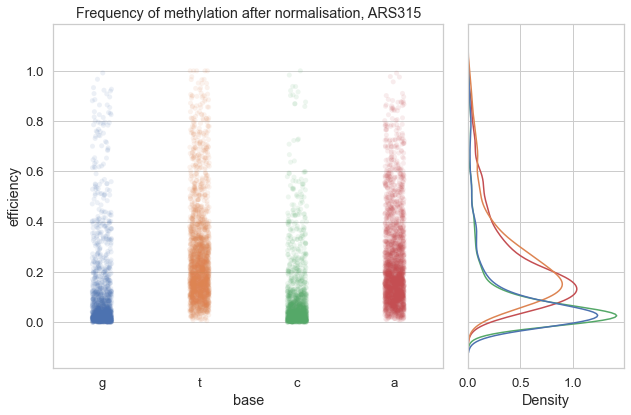

In [141]:
#prepare the data:
seq="GTTTTTTCTTTTCAGCACTGCGAAAGAGAGAGCAACGGTAAAGAGCATGAGCCAATTTGAAAAGCAGAAGGAACAGGGCAATTCTTTGTTCAAACAGGGCCTGTATCGCGAGGCTGTGCACTGTTATGACCAACTAATTACTGCTCAACCGCAGAACCCGGTCGGGTACAGCAACAAAGCCATGGCGCTGATCAAACTGGGTGAATATACACAGGCTATTCAAATGTGCCAGCAAGGACTGCGGTACACCTCAACGGCAGAGCATGTAGCTATCAGATCCAAATTGCAATATCGTCTAGAGCTGGCACAGGGAGCGGTAGGTTCAGTACAGATCCCTGTTGTAGAGGTTGATGAACTACCGGAGGGATACGACCGGTCCTGAGAAAAGAGAAAGGGAACACTTCTAATTTATCTTTAAAATTATATATATATATATATATATATGTGTGTTTGTATACTCTGTGGGTATTTCCGTGTATATGGTTAATAATAGTAGTATCTTGTCAGTTTTTTTTATGTTTTTCTTCGCGCGTCAACTTTCTACCAAGAGAAAAACAATATAAGGTCTCCTTACTCTATAGGAGAATAAAACAAACAAAAATAAAAAGCACATCGTAGCGCCAAGAAAATACTGCAAATACCAAATACCACAATAATACTACAATTATCTATACACAAGTGTTTTGCCGCTTAAAACTTCGATTTTCATAGTACGAAACTATACACCCTTGGTTTTTCTCTTTTCTAAATACATATCTACCTTGTAAAGAATTTCCCGCACATCTTTGCGGGCATACAGTTCATGTATTGGCAACTAACGGAACTAAGGCAACATATCTTGCATATTGCAATGTTCACTATATAGATGAAAACTTATATCTAGGTTTCACGACACGAGAATAACTAAGAAGCACGATCCATGATATAGAAAAATCAGTTACGACGAAGCACGGCAAATTAGCCGCCGAAGACCGATATTTTTGCCACCGGTCACAGTTTTCTTTTCCACGGAGCTCTTCGCGGTTTTTTTGTTCCGGATTTTTTTTACCGGCTCTTAGCGGACCGTTTTGGTTATAAGGGGAGTGGCAGCGGCGGTAGACACTGCGCTCTATAAGAATACTTGCAAGGGTCTTGTCTATTGTATAATTCGCTAGTATTTGTTTTGCATTGTACTCTTAATACCCCAACCgggagcttgcatgccggtcgaccacgatttgatgaaagaataacgta"
seq=seq.lower()
#eff_df = pd.DataFrame({"wt_rep3": wt_rep3.mean(axis=0)}, index=range(1236))
eff_df = pd.DataFrame({"wt_rep3": wt_rep3_minmax}, index=range(1236))

eff_df["base"] = [letter for letter in seq]
#eff_df["wt_rep2"] = wt_rep2.mean(axis=0)
#eff_df["dies6_rep1"] = dies6_rep1.mean(axis=0)
#eff_df["dies6_rep2"] = dies6_rep2.mean(axis=0)
#eff_df["disw2_rep1"] = disw2_rep1.mean(axis=0)
#eff_df["disw2_rep2"] = disw2_rep2.mean(axis=0)


eff_df["wt_rep2"] = wt_rep2_minmax
eff_df["dies6_rep1"] = dies6_rep1_minmax
eff_df["dies6_rep2"] = dies6_rep2_minmax
eff_df["disw2_rep1"] = disw2_rep1_minmax
eff_df["disw2_rep2"] = disw2_rep2_minmax

eff_df_melt = eff_df.melt(id_vars="base", var_name= "sample", value_name="efficiency")

# specify plot layouts with different width using subplots()
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

f, axs = plt.subplots(1,2,
                      figsize=(9,6),
                      sharey=True,
                     gridspec_kw=dict(width_ratios=[2.5,1]))
# make scatterplot with legends
sns.stripplot(data = eff_df_melt, x = "base", y = "efficiency", alpha=0.1, ax= axs[0])
axs[0].set_title("Frequency of methylation after normalisation, ARS315")
axs
# make densityplot with kdeplot without legends
sns.kdeplot(data= eff_df_melt,
                y="efficiency",
                hue="base",
                ax=axs[1],
                legend=False, warn_singular=False)
f.tight_layout()
#plt.savefig(load_dir + "/plots/methylation_efficiency_ARS313.tif", dpi=300)

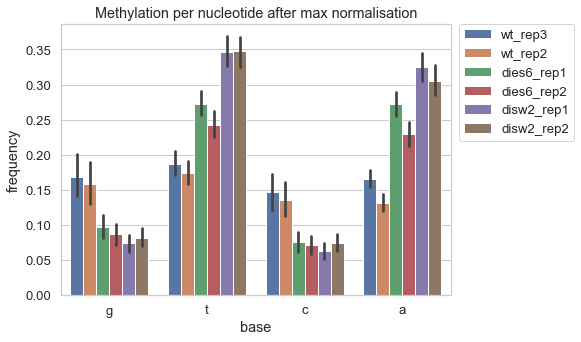

In [142]:
plt.figure(figsize=(7,5))
sns.barplot(data=eff_df_melt, x = "base", y = "efficiency", hue = "sample")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.title("Methylation per nucleotide after max normalisation")
plt.ylabel("frequency")
#plt.savefig(load_dir + "/plots/methylation_efficiency_naked_plasmid_per_sample.tif", dpi=300, bbox_inches='tight')
plt.show()

<AxesSubplot:title={'center':'Normalized methylation over samples'}, xlabel='sample', ylabel='normalized frequency of methylation'>

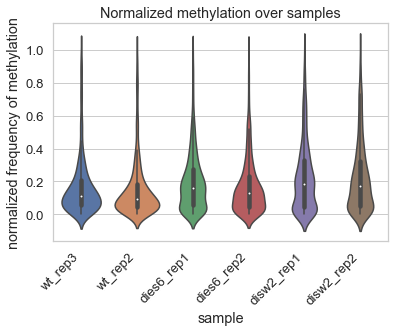

In [143]:
g = sns.violinplot(data = eff_df_melt, x = "sample", y = "efficiency", alpha=0.1)
g.set_ylabel("normalized frequency of methylation")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title("Normalized methylation over samples")

g

In [152]:
#Exporting aggregated data for Anna to plot for the manuscript 
#2nd June 2022

smooth = {"wt_pooled": np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
          "wt_rep3": np.convolve(wt_rep3_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
          "wt_rep2": np.convolve(wt_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_rep1": np.convolve(dies6_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_rep2": np.convolve(dies6_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_pooled": np.convolve(pooled_dies6, np.ones(smooth_width)/smooth_width, mode="same"),
         "disw2_rep1": np.convolve(disw2_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "disw2_rep2": np.convolve(disw2_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "disw2_pooled": np.convolve(pooled_disw2, np.ones(smooth_width)/smooth_width, mode="same")}


ARS315_smooth_30 = pd.DataFrame.from_dict(smooth)
ARS315_smooth_30.index = ARS315_smooth_30.index + 1
#ARS315_smooth_30.to_csv("ARS315/ARS315_smoothed_average_methylation_winsize_30.csv")

FC = {
    "dies6_pooled" : np.convolve(pooled_dies6, np.ones(smooth_width)/smooth_width, 
                                 mode="same")/np.convolve(pooled_wt, 
                                                          np.ones(smooth_width)/smooth_width, mode="same"),
    "disw2_pooled" : np.convolve(pooled_disw2, np.ones(smooth_width)/smooth_width, 
                                 mode="same")/np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode="same")
}

ARS315_FCs = pd.DataFrame.from_dict(FC)
ARS315_FCs.index = ARS315_FCs.index + 1

#ARS315_FCs.to_csv("ARS315/ARS315_smoothed_fold_changes_winsize_30.csv")